In [30]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [31]:
def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides, padding=padding, activation='relu', name='zjtest_conv2d_L1'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu',name='zjtest_conv2d_L2'),
        tf.keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu',name='zjtest_conv2d_L3')
    ])

In [32]:
def net():
    return tf.keras.models.Sequential([
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Reshape((1,1,10)),
        tf.keras.layers.Flatten()
    ])

In [33]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Reshape output shape:	 (1, 1, 1, 10)
Flatten output shape:	 (1, 10)


loss 0.252, train acc 0.908, test acc 0.887
3117.1 examples/sec on /GPU:0


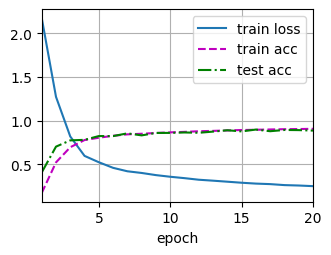

In [34]:
lr, num_epochs, batch_size = 0.1, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
nin_net = d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [35]:
print(nin_net.summary())

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_45 (Sequential)      │ (128, 54, 54, 96)      │        30,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (128, 26, 26, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_46 (Sequential)      │ (128, 26, 26, 256)     │       746,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (128, 12, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_47 (Sequential)      │ (128, 12, 12, 384)     │     1,180,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (128, 5, 5, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (128, 5, 5, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_48 (Sequential)      │ (128, 5, 5, 10)        │        34,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (128, 10)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (128, 1, 1, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (128, 10)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,168 (7.60 MB)

 Trainable params: 1,992,166 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [36]:
nin_net.save_weights(filepath='nin_net.weights.h5')

In [37]:
clone = net()
clone_test = net()
print(clone_test.summary())

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_55 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_56 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_57 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_58 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
for x,y in train_iter:
    clone(x)
    break
print(clone.summary())

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_50 (Sequential)      │ (128, 54, 54, 96)      │        30,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (128, 26, 26, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_51 (Sequential)      │ (128, 26, 26, 256)     │       746,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (128, 12, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_52 (Sequential)      │ (128, 12, 12, 384)     │     1,180,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (128, 5, 5, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (128, 5, 5, 384)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_53 (Sequential)      │ (128, 5, 5, 10)        │        34,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (128, 10)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (128, 1, 1, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (128, 10)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,992,166 (7.60 MB)

 Trainable params: 1,992,166 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [39]:
clone.load_weights(filepath='nin_net.weights.h5')

In [40]:
#保存、加载模型，网络模式
nin_net.save("nin_model.keras")

In [41]:
infer = tf.keras.models.load_model("nin_model.keras")
for x,y in train_iter:
    infer(x)
    break
print(len(infer.layers))

11


In [42]:
nin_net.export("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='keras_tensor_354')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140696015086592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122549152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122551792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122550736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140696386816480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122552672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122558480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122551968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122552848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140699122560064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14069601542643

In [43]:
info_sv = tf.keras.layers.TFSMLayer('saved_model', call_endpoint='serving_default')
for x,y in train_iter:
    output = info_sv(x)
    print(output)
    break
print(info_sv)

{'output_0': <tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[ 1.4148113 ,  1.1404774 ,  3.5848281 , ..., 17.243114  ,
        10.15524   , 16.492773  ],
       [ 6.5058594 ,  1.9144822 , 11.542385  , ...,  1.1665244 ,
         5.8906207 ,  0.11390016],
       [ 9.063105  ,  4.2110004 , 14.450374  , ...,  0.13979661,
         5.3185267 ,  0.39386532],
       ...,
       [ 3.6825805 ,  1.9893064 ,  9.848098  , ...,  2.3685107 ,
         6.28433   ,  0.6786225 ],
       [ 3.6495216 ,  0.69543165, 12.486015  , ...,  1.3347843 ,
         6.783655  ,  0.06079325],
       [ 9.666457  ,  6.4059143 ,  9.334098  , ...,  0.97748893,
         5.2492933 ,  0.14842352]], shape=(128, 10), dtype=float32)>}
<TFSMLayer name=tfsm_layer_2, built=True>
